## Imports

In [6]:
import os
import matplotlib.pyplot as plt
from PIL import Image, ImageFile
import pandas as pd
import numpy as np

import tez
from tez.datasets import ImageDataset
from tez.callbacks import EarlyStopping

import torch
import torch.nn as nn

import torchvision

from sklearn import metrics, model_selection
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
from tqdm.auto import tqdm

import csv


%matplotlib inline

## Config

In [7]:
VERSION = 'v102'
MODEL_PATH = './Model/model' + VERSION + '.bin'
TEST_PREDICTION_FILE = './TargetData-Test-Prediction-' + VERSION + '.csv'
CLASS_ACCURACY_FILE = './TargetData-Test-Accuracy-' + VERSION + '.csv'

IMAGE_SIZE = (400, 400)
TRAIN_BATCH_SIZE  = 32
VALID_BATCH_SIZE = 32
TEST_BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 6e-5

TRAINING_DATA_PATH = './TargetData-200-Train.csv'
VALIDATION_DATA_PATH = './TargetData-200-Valid.csv'
TEST_DATA_PATH = './TargetData-200-Test.csv'

IMAGE_FOLDER_PATH = './TargetImages-200/'

device = torch.device("cuda")
torch.cuda.empty_cache()
print(f'Device: {device}')

Device: cuda


## Dataset

In [8]:
class GLRDataset:
    def __init__(self, image_paths, targets, augmentations=None):
        self.image_paths = image_paths
        self.targets = targets
        self.augmentations = augmentations
        
    def __len__(self):
        return len(self.image_paths)    
    
    def __getitem__(self, item):
        targets = self.targets[item]
        image = Image.open(self.image_paths[item])
        augmented_image = self.augmentations(image)
        image_tensor = torch.tensor(np.transpose(np.array(augmented_image), (2, 0, 1)).astype(np.float32))
        
        return {
            'image': image_tensor,
            'targets': torch.tensor(targets),
        }

In [9]:
# Training Data
df_train = pd.read_csv(TRAINING_DATA_PATH)
train_image_paths = [
    os.path.join(IMAGE_FOLDER_PATH, x + '.jpg') for x in df_train.id.values
]
train_targets = df_train.label.values
train_aug = torchvision.transforms.Compose(
    [
        torchvision.transforms.RandomResizedCrop(size=(IMAGE_SIZE[0], IMAGE_SIZE[1]))
    ]
)
train_dataset = GLRDataset(
    image_paths = train_image_paths,
    targets = train_targets,
    augmentations = train_aug
)
train_data_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True
)
print(f'Total Batches in Train: {len(train_data_loader)}')
###############################################################

# Validation Data
df_valid = pd.read_csv(VALIDATION_DATA_PATH)
valid_image_paths = [
    os.path.join(IMAGE_FOLDER_PATH, x + '.jpg') for x in df_valid.id.values
]
valid_targets = df_valid.label.values
valid_aug = torchvision.transforms.Compose(
    [
        torchvision.transforms.CenterCrop(size=(IMAGE_SIZE[0], IMAGE_SIZE[1])),
        torchvision.transforms.Resize(size=(IMAGE_SIZE[0], IMAGE_SIZE[1]))
    ]
)
valid_dataset = GLRDataset(
    image_paths = valid_image_paths,
    targets = valid_targets,
    augmentations = valid_aug
)
valid_data_loader = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=VALID_BATCH_SIZE,
    shuffle=False
)

print(f'Total Batches in Validation: {len(valid_data_loader)}')
###############################################################


# Test Data
df_test = pd.read_csv(TEST_DATA_PATH)
test_image_paths = [
    os.path.join(IMAGE_FOLDER_PATH, x + '.jpg') for x in df_test.id.values
]
test_targets = df_test.label.values
test_aug = torchvision.transforms.Compose(
    [
        torchvision.transforms.CenterCrop(size=(IMAGE_SIZE[0], IMAGE_SIZE[1])),
        torchvision.transforms.Resize(size=(IMAGE_SIZE[0], IMAGE_SIZE[1]))
    ]
)
test_dataset = GLRDataset(
    image_paths = test_image_paths,
    targets = test_targets,
    augmentations = test_aug
)

test_data_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=TEST_BATCH_SIZE,
    shuffle=False
)

print(f'Total Batches in Test: {len(test_data_loader)}')
###############################################################

Total Batches in Train: 4246
Total Batches in Validation: 472
Total Batches in Test: 525


## Plot Images

In [10]:
def plot_img(image_dict):
    image_tensor = image_dict['image']
    target = image_dict['targets']
    print(f'Target: {target}')
    plt.figure(figsize=(10, 10))
    image = image_tensor.permute(1, 2, 0) / 255
    plt.imshow(image)

Target: 480


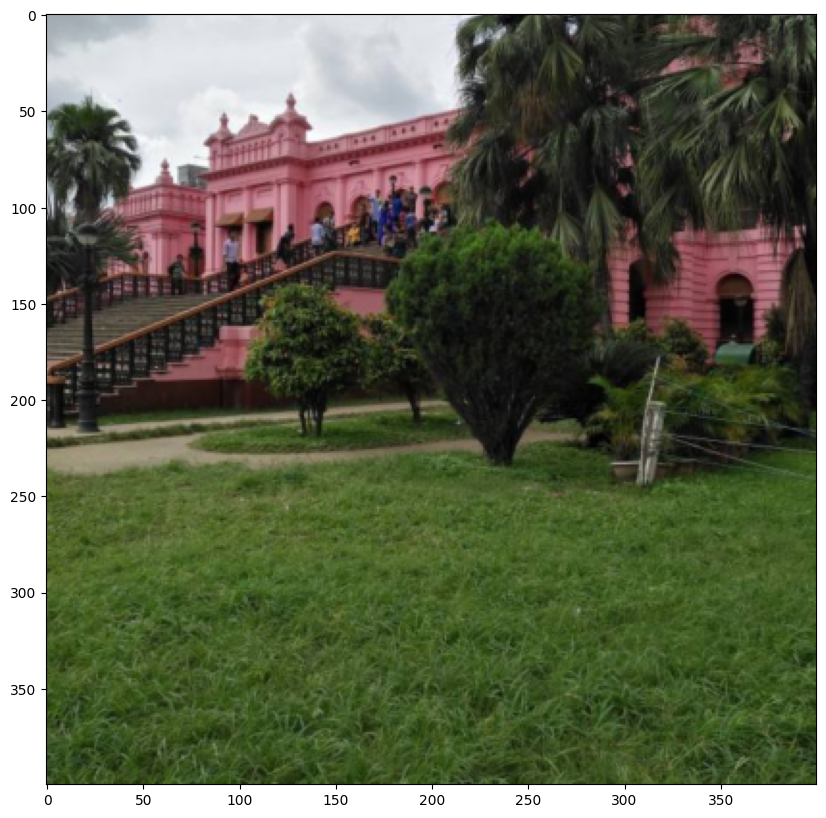

In [11]:
plot_img(train_dataset[10])

## Model

In [12]:
class GLRModel(tez.Model):
    def __init__(self, num_classes):
        super().__init__()
        self.convnet = torchvision.models.resnet101(pretrained=True)
        self.convnet.fc = nn.Linear(2048, num_classes)   
    
    def forward(self, image):
        outputs = self.convnet(image)        
        return outputs

## Loss Function & Metric

In [13]:
def loss_function(outputs, targets):
    return nn.CrossEntropyLoss()(outputs, targets)
    
def count_correct(outputs, targets):
    outputs = torch.argmax(outputs, dim=1).cpu().detach().numpy()
    targets = targets.cpu().detach().numpy()
    total_correct = np.sum(outputs == targets)
    
    return total_correct

## Training

In [ ]:
NUM_CLASSES = df_train.label.nunique()
model = GLRModel(num_classes = NUM_CLASSES)
model.to(device)

param_optimizer = list(model.named_parameters())
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
optimizer_parameters = [
    {
        "params": [
            p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
        ],
        "weight_decay": 0.005,
    },
    {
        "params": [
            p for n, p in param_optimizer if any(nd in n for nd in no_decay)
        ],
        "weight_decay": 0.0,
    },
]

num_train_steps = int(len(train_data_loader) * EPOCHS)
optimizer = torch.optim.AdamW(optimizer_parameters, lr=LEARNING_RATE)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=500,
    num_training_steps=num_train_steps
)

best_loss = float('inf')
print(f'Model Training Started')

for epoch in range(EPOCHS):
        
    total_train_loss = 0.0
    total_train_correct = 0
    for batch_index, data in tqdm(enumerate(train_data_loader), total=len(train_data_loader)):        
        
        image = data['image']
        targets = data['targets']
        
        image = image.to(device)
        targets = targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(image=image)        
        
        loss = loss_function(outputs, targets)
        
        with torch.no_grad():
            total_train_loss += loss.item()
            total_train_correct += count_correct(outputs, targets)
        
        loss.backward()
        optimizer.step()
        scheduler.step()
        
    total_valid_loss = 0.0
    total_valid_correct = 0
    with torch.no_grad():
        model.eval()
        for batch_index, data in tqdm(enumerate(valid_data_loader), total=len(valid_data_loader)):
            image = data['image']
            targets = data['targets']
        
            image = image.to(device)
            targets = targets.to(device)
        
            outputs = model(image=image)
            
            validloss = loss_function(outputs, targets)
            total_valid_loss += validloss.item()            
            total_valid_correct += count_correct(outputs, targets)
            
        total_valid_loss = total_valid_loss / len(valid_data_loader)
        total_train_loss = total_train_loss / len(train_data_loader)
        print(f'Epoch: {epoch + 1} :: Training Loss: {total_train_loss:.4f}, Validation Loss: {total_valid_loss:.4f}')
        print(f'Training Accuracy: {total_train_correct / len(train_dataset) * 100:.2f}, Validation Accuracy: {total_valid_correct / len(valid_dataset) * 100:.2f}')
        
        if total_valid_loss < best_loss:
            torch.save(model.state_dict(), MODEL_PATH)
            best_loss = total_valid_loss

In [ ]:
NUM_CLASSES = df_train.label.nunique()
loaded_model = GLRModel(num_classes = NUM_CLASSES)
loaded_model.to(device)
loaded_model.load_state_dict(torch.load(MODEL_PATH))
loaded_model.eval()

total_test_correct = 0
index = 0
df_test['prediction'] = 'Missing Prediction'
with torch.no_grad():
        for batch_index, data in tqdm(enumerate(test_data_loader), total=len(test_data_loader)):
            image = data['image']
            targets = data['targets']
        
            image = image.to(device)
            targets = targets.to(device)
        
            outputs = loaded_model(image=image)
            total_test_correct += count_correct(outputs, targets)
            outputs = torch.argmax(outputs, dim=1).cpu().detach().numpy()
            for i in range(len(targets)):                            
                df_test['prediction'][index] = outputs[i]
                index += 1             

                
print(f'Test Accuracy: {total_test_correct / len(test_dataset) * 100:.2f}')       
df_test.to_csv(TEST_PREDICTION_FILE, sep=',')

In [ ]:
df_prediction = pd.read_csv(TEST_PREDICTION_FILE)
class_correct_count = {}
class_total_count = {}
index = 0
for label in df_prediction.label.values:
    if label not in class_total_count:
        class_total_count[label] = 0
        class_correct_count[label] = 0
        
    if label == df_prediction.prediction[index]:
        class_correct_count[label] += 1
    
    class_total_count[label] += 1
    index+=1


In [ ]:
accuracy_sum = 0.0

with open(CLASS_ACCURACY_FILE, "w", newline='') as filec:
    writerc = csv.writer(filec, delimiter=',')
    writerc.writerow(('class_id','total_count', 'total_correct', 'accuracy'))
    
    for class_id, total_count in class_total_count.items():
        total_correct = class_correct_count[class_id]
        accuracy = total_correct / total_count * 100.0
        accuracy_sum += accuracy
        writerc.writerow((class_id, total_count, total_correct, round(accuracy, 2)))
        
        
print(f'Balanced Accuracy: {accuracy_sum / NUM_CLASSES :.2f}')

In [ ]:
target_class = 29
target_class_index = 8
count = 0 
for index in range(len(train_dataset)):
    if train_dataset[index]['targets'] == target_class:
        count += 1        
        if count == target_class_index:        
            plot_img(train_dataset[index])
            break